# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2024-2025, Q4
* Course homepage: https://brightspace.tudelft.nl/d2l/home/682445
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Niels Stienen (N.L.Stienen@student.tudelft.nl)
* (c) TU Delft, 2025

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please **do not** delete it, instead run that cell as you would run all other cells. Finally, please **do not** add any extra cells to this notebook or change the existing cells unless you are explicitly asked to do so.

Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Mart Veldkamp"
STUDENT_1_STUDENT_NUMBER = "5885175"
STUDENT_1_NETID = "mmveldkamp"
STUDENT_1_EMAIL = "m.m.veldkamp@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. Please note that it is **not** allowed to post any code relating to solution attempts. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA or if not possible otherwise, send an email to the instructor or TA.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. 

* Please note that the above mentioned _read-only_ protection only works in Jupyter Notebook, and it does not work if you open this notebook in another editor (e.g., VSCode, PyCharm, etc.). Therefore, we recommend that you only use Jupyter Notebook for this course. If you use any other editor, you may accidentally delete cells, modify the tests, etc., which would cause you to lose points.

* If you edit a function that is imported in another notebook, you need to **restart the kernel** of the notebook where you are using the function. Otherwise, the changes will not be effective.

* **IMPORTANT**: Please make sure that your code executes without any errors before submitting the notebook. An easy way to ensure this is to use the validation script as described in the README.

# Task 2c.5 - Control with the learned dynamics (15p)

**Author:** Maximilian Stölzle

**For inquiries, contact:** Jingyue Liu (J.Liu-14@tudelft.nl)

Now, we can finally use the learned model for control. Namely, please simulate the closed-loop system with a PD+ controller, which is / should be implemented in the `ctrl_ff_pd_plus` function in the `controllers.ipynb` notebook. This is the same control strategy as in Task 2a.4, but now instead of the analytical, the learned dynamical matrices shall be used in the control law. With feedback gains of $k_\mathrm{p} = \mathrm{diag}(500, 500)$, $k_\mathrm{d} = \mathrm{diag}(50, 50)$, your controller should achieve a better performance than a pure PD feedback controller with the same gains.

If you correctly implement this task, you will receive a baseline of 3 points. The remaining 12 points are distributed based on the control performance. You will receive full points for this task if the Euclidean norm of the RMSE of the end-effector position between the reference trajectory and the actual robot evolution is **below** 0.06 m. If the error is between 0.06 m and 0.68 m, your grade will be linarly scaled with the error. However, if the error is larger than 0.68 m, you will not receive any credits for the control performance.

In [3]:
import sys
# Had a problem with jax_double_pendulum not being found, so i had to add the path manually
sys.path.append("/home/murt/ics-pa-sv/")

In [4]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
import dill
from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
import jax

jax.config.update("jax_platforms", "cpu")  # set default device to 'cpu'
jax.config.update("jax_enable_x64", True)  # double precision
from jax import jit, lax, random
from jax import numpy as jnp
from matplotlib import rcParams
import matplotlib.pyplot as plt
import os
from pathlib import Path
from progressbar import progressbar
from typing import Dict, Tuple

from jax_double_pendulum.analysis import *
from jax_double_pendulum.motion_planning import (
    generate_ellipse_trajectory,
    ELLIPSE_PARAMS,
)
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.visualization import animate_robot

# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))
# define tolerances for grading
RTOL = float(os.environ.get("RTOL", "1e-4"))  # relative tolerance
ATOL = float(os.environ.get("ATOL", "1e-7"))  # absolute tolerance

In [5]:
# simulation parameters
sim_duration = 10.0  # [s]
sim_dt = 1e-2  # [s]

# controller parameters
# PD feedback gains
kp = 500 * jnp.eye(2)  # [Nm/rad]
kd = 50 * jnp.eye(2)  # [Nm s/rad]

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

# generate ellipse trajectory
traj_ts = generate_ellipse_trajectory(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

# specify the initial link angles
th_0 = traj_ts["th_ts"][0] - jnp.array([0.1, 0.2])

Please implement a closed-loop simulation below, which uses a PD+ controller for trajectory tracking. The controller is **not** allowed to use any information from the nominal robot model, but rather needs to use the dynamical matrices generated by the Lagrangian neural network.

In [10]:
# load the save neural network params
statedict_path = str(Path("statedicts") / "task_2c_lagrangian_nn_params.pkl")
with open(statedict_path, "rb") as f:
    nn_params = dill.load(f)

# import the lagrangian neural network dynamical matrices function
from ipynb.fs.full.lnn import dynamical_matrices as lnn_dynamical_matrices

# use partial to make the `lnn_dynamical_matrices_fn` conform to the interface
#   M, C, G = lnn_dynamical_matrices_fn(th, th_d)
lnn_dynamical_matrices_fn = None
# YOUR CODE HERE
lnn_dynamical_matrices_fn = lambda th, th_d: lnn_dynamical_matrices(
    nn_params["MassMatrixNN"],
    nn_params["PotentialEnergyNN"],
    th,
    th_d
)

# import the PD feedback and the feed-forward term of the PD+ controller from controllers.ipynb
from ipynb.fs.full.controllers import ctrl_fb_pd, ctrl_ff_pd_plus

# Simulate the closed-loop system with the PD+ controller.
# The controller is only allowed to access the dynamical matrices provided by the Lagrangian neural network.
# Finally, save the simulation data to the `sim_ts` variable.
sim_ts = None
# YOUR CODE HERE
sim_ts = simulate_robot(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=jnp.zeros((2,)),
    th_des_ts=traj_ts["th_ts"],
    th_d_des_ts=traj_ts["th_d_ts"],
    th_dd_des_ts=traj_ts["th_dd_ts"],
    ctrl_fb=partial(ctrl_fb_pd, kp=kp, kd=kd),
    ctrl_ff=partial(ctrl_ff_pd_plus, lnn_dynamical_matrices_fn),
)

rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(traj_ts, sim_ts)
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts)
with jnp.printoptions(precision=3):
    print(
        "RMSE theta:",
        rmse_th,
        "rad, RMSE theta_d:",
        rmse_th_d,
        "rad/s, RMSE theta_dd:",
        rmse_th_dd,
        "rad/s^2",
    )
    print(
        "RMSE x:",
        f"{jnp.linalg.norm(rmse_x):.4f}",
        "m, RMSE x_d:",
        f"{jnp.linalg.norm(rmse_x_d):.3f}",
        "m/s, RMSE x_dd:",
        f"{jnp.linalg.norm(rmse_x_dd):.2f}",
        "m/s^2",
    )

RMSE theta: [0.049 0.022] rad, RMSE theta_d: [0.156 0.149] rad/s, RMSE theta_dd: [0.662 2.419] rad/s^2
RMSE x: 0.1024 m, RMSE x_d: 0.382 m/s, RMSE x_dd: 3.01 m/s^2


In [11]:
# DO NOT REMOVE OR MODIFY THIS CELL

rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(traj_ts, sim_ts)
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts)

grader_max_impl_points = 3  # points for a correct implementation
grader_max_perf_points = 12  # points for a good control performance

rmse_x_norm = jnp.linalg.norm(rmse_x)  # achieved RMSE in operational space
rmse_x_lb = 0.06  # m --> this will result in the full grade
rmse_x_ub = 0.68  # m --> this will result in zero points for the control performance

grader_perf_points = grader_max_perf_points * (
    (1 - (rmse_x_norm - rmse_x_lb) / (rmse_x_ub - rmse_x_lb))
)
grader_perf_points = jnp.clip(grader_perf_points, 0, grader_max_perf_points).item()

grader_points = grader_max_impl_points + grader_perf_points

print(
    f"If you submit the assignment as it is, you will receive {grader_points} points."
)


grader_points

If you submit the assignment as it is, you will receive 14.179640860267218 points.


14.179640860267218

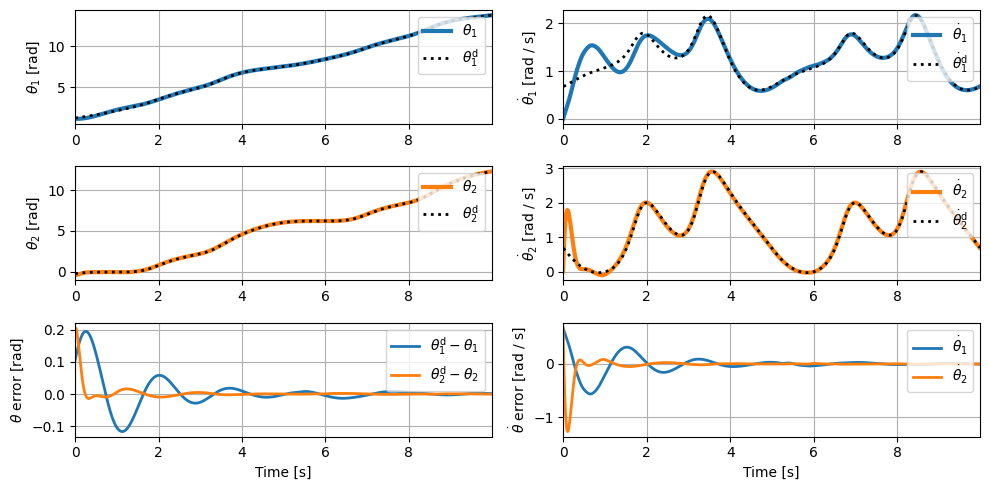

In [12]:
# plot the configuration-space evolution
plot_configuration_space_trajectory_following(
    traj_ts,
    sim_ts,
    filepath=str(
        outputs_dir / "task_2c-5_configuration_space_trajectory_following.pdf"
    ),
)

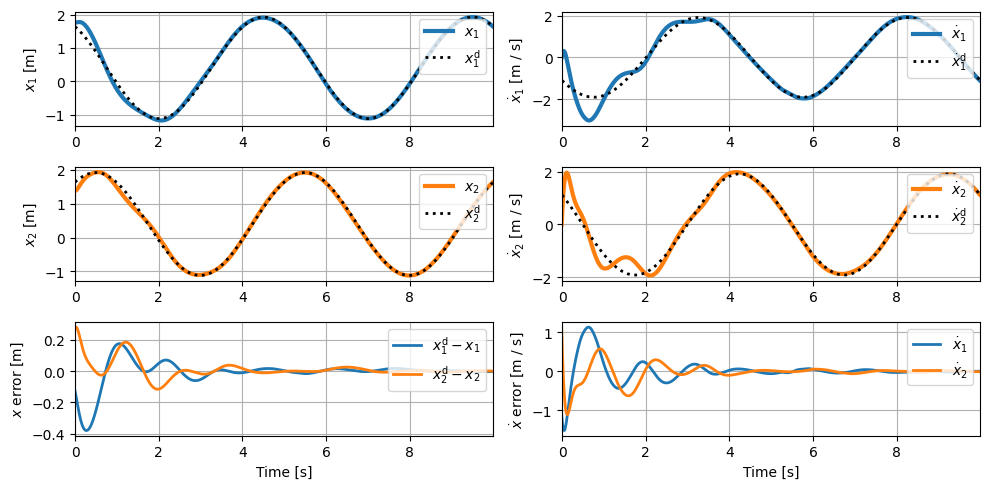

In [13]:
# plot the operational-space evolution
plot_operational_space_trajectory_following(
    traj_ts,
    sim_ts,
    filepath=str(outputs_dir / "task_2c-5_operational_space_trajectory_following.pdf"),
)

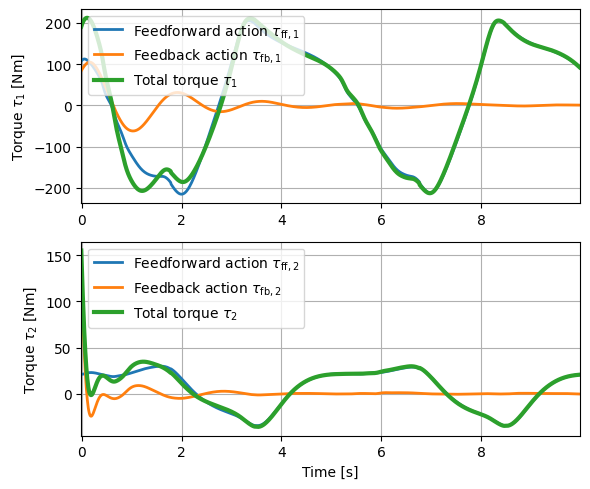

In [14]:
# plot the actuation throughout the evolution
plot_actuation(sim_ts, filepath=str(outputs_dir / "task_2c-5_actuation.pdf"))

In [15]:
# animate this simulation
if not AUTOGRADING:
    ani = animate_robot(
        rp=ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(outputs_dir / "task_2c-5_controlled_robot.mp4"),
    )
    display(HTML(ani.to_html5_video()))